In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from torchvision.models.resnet import BasicBlock

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm
import pickle as pk
import os
import glob

import matplotlib.pyplot as plt

from structures import LateralInhibition, LIBlock


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

using cuda


## Load and normalize ImageNet

In [2]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

TRAIN_NORMALIZE = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(0.75, 1.33)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN.tolist(), std=IMAGENET_STD.tolist()),
        transforms.RandomHorizontalFlip(),
    ]
)

TEST_NORMALIZE = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN.tolist(), std=IMAGENET_STD.tolist()),
    ]
)

def deprocess(img):
    transform = transforms.Compose(
        [
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / IMAGENET_STD).tolist()),
            transforms.Normalize(mean=(-IMAGENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)


def load_datas(batch_size=128, root=""):
    train_dataset = ImageFolder(root=f"{root}imagenet-mini/train", transform=TRAIN_NORMALIZE)
    test_dataset = ImageFolder(root=f"{root}imagenet-mini/val", transform=TEST_NORMALIZE)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

    return train_loader, test_loader

train_loader, test_loader = load_datas()
TRAIN_SIZE, TEST_SIZE = len(train_loader.dataset), len(test_loader.dataset)

print(f"train dataset: {TRAIN_SIZE}, test_dataset: {TEST_SIZE}")

train dataset: 34745, test_dataset: 3923


## Utils

In [3]:
def train_model(
    model, num_epochs=50, batch_accumulation=2, eval_freq=5, comment="", verbose=0
):
    writer = SummaryWriter(comment=comment)


    # Setup training
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # loss and accuracy records
    train_loss_record = []
    train_accuracy_record = []
    test_loss_record = []
    test_accuracy_record = []

    # Train
    for epoch in range(num_epochs):
        total_loss, correct = 0, 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            pred = output.argmax(dim=1)

            # compute batch accuracy
            correct += torch.sum(labels == pred).sum().item()

            # compute the loss and accumulate it
            loss = criterion(output, labels) / batch_accumulation
            total_loss += loss
            loss.backward()

            if (batch_idx + 1) % batch_accumulation:
                optimizer.step()
                optimizer.zero_grad()

        # decrease learning rate
        scheduler.step()

        total_loss /= TRAIN_SIZE
        accuracy = correct / TRAIN_SIZE

        writer.add_scalar("Train/loss", total_loss, epoch)
        writer.add_scalar("Train/accuracy", accuracy, epoch)

        train_loss_record.append(total_loss.item())
        train_accuracy_record.append(accuracy)

        if verbose:
            print(
                f"[{epoch + 1:2d}/{num_epochs}] loss_train: {total_loss:.2E} accuracy_train: {accuracy:.2%}"
            )

        if (epoch + 1) % eval_freq:
            continue

        with torch.no_grad():
            test_loss, correct = 0, 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                pred = output.argmax(dim=1)

                correct += torch.sum(labels == pred).sum().item()

                loss = criterion(output, labels)
                test_loss += loss

            test_loss /= TEST_SIZE
            accuracy = correct / TEST_SIZE

            writer.add_scalar("Test/loss", test_loss, epoch)
            writer.add_scalar("Test/accuracy", accuracy, epoch)

            test_loss_record.append(test_loss.item())
            test_accuracy_record.append(accuracy)

        if verbose:
            print(f"loss_test: {total_loss:.2E} accuracy_test: {accuracy:.2%}")

    # saving logs and model
    log_path = "logs/"
    model_name = type(model).__name__

    # find last model run id
    max_run_id = 0
    for path in glob.glob(os.path.join(log_path, model_name + "_[0-9]*")):
        file_name = os.path.basename(path)
        ext = file_name.split("_")[-1]
        if (
            model_name == "_".join(file_name.split("_")[:-1])
            and ext.isdigit()
            and int(ext) > max_run_id
        ):
            max_run_id = int(ext)

    file_name = model_name + f"_{max_run_id+1}"
    save_dir = os.path.join(log_path, file_name)
    os.mkdir(save_dir)

    log = {
        "train_loss": train_loss_record,
        "train_accuracy": train_accuracy_record,
        "test_loss": test_loss_record,
        "test_accuracy": test_accuracy_record,
    }

    with open(os.path.join(save_dir, "log.pkl"), "wb") as f:
        pk.dump(log, f)

    torch.save(model, os.path.join(save_dir, "model.pth"))

    print(f"Model saved in: {save_dir}")


def evaluate(model, data_loader):
    model = model.eval()
    correct = 0
    for _, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        pred = torch.argmax(model(images), dim=1)
        correct += torch.sum(labels == pred).sum().item()

    print(f"accuracy: {correct / len(data_loader.dataset):.2%}")

In [4]:
def plot_weights_heatmap(model):
    assert hasattr(model, "log")

    weights = [t.flatten().detach().cpu() for t in model.log["W"]]

    w_min = torch.cat(weights).min()
    w_max = torch.cat(weights).max()

    bins = np.linspace(w_min, w_max, 20)
    counts = np.zeros((len(weights), len(bins) - 1))

    for i, W in enumerate(weights):
        for j in range(len(bins) - 1):
            counts[i][j] = ((W >= bins[j]) & (W < bins[j + 1])).sum().item()

    counts /= counts.sum(axis=1).reshape(-1, 1)

    fig, ax = plt.subplots()

    labels = [r"$LI_{}$".format(i + 1) for i in range(counts.shape[0])]
    xticks = [f"{bins[i] + bins[i+1] / 2:.2f}" for i in range(bins.size - 1)]

    ax.imshow(counts, cmap="Blues", interpolation="nearest")
    ax.set_xticks(np.arange(counts.shape[1]), xticks, rotation=45)
    ax.set_yticks(np.arange(counts.shape[0]), labels)

    plt.title("LI-layers weights heatmap")
    plt.tight_layout()
    plt.show()


def plot_log(model_path, key="accuracy"):
    with open(f"{model_path}/log.pkl", "rb") as f:
        log = pk.load(f)

    model_name = model_path.split("/")[1].split("_")[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(log[f"train_{key}"], label=f"{model_name}")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel(key)
    ax[0].set_title(f"Train {key}")
    ax[0].legend()

    ax[1].plot(log[f"test_{key}"], label=f"{model_name}")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel(key)
    ax[1].set_title(f"Test {key}")
    ax[1].legend()

    plt.show()


## AlexNet

### Baseline

In [5]:
alexnet = models.alexnet(weights=None).to(device)
train_model(alexnet, 90, 2, 5, f"_AlexNet", verbose=0)

2023-02-13 03:59:27.671784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 03:59:28.338955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-13 03:59:28.339076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-13 03:59:28.339095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Model saved in: logs/AlexNet_2


In [ ]:
model_path = "logs/AlexNet_1"

model = torch.load(f"{model_path}/model.pth")
evaluate(model, test_loader)
plot_log(model_path)

### Alexnet+LI

In [6]:
class AlexNetLI(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(AlexNetLI, self).__init__()

        alexnet = models.alexnet(weights=weights)

        self.log = {"W": [], "m": [], "v": [], "b": []}

        # Rebuild alexnet features, by adding a LI layer after each convolutions'
        # activation function
        features = list(alexnet.features.children())
        new_features = []

        for i, l in enumerate(features):
            new_features.append(l)
            if isinstance(l, nn.ReLU):
                li = LateralInhibition(features[i - 1].out_channels)
                new_features.append(li)
                self.log["W"].append(li.weights)
                self.log["m"].append(li.m)
                self.log["v"].append(li.v)
                self.log["b"].append(li.b)

        self.features = nn.Sequential(*new_features)

        # Copy all the non-convolutional parts of AlexNet
        self.avg_pool = alexnet.avgpool
        self.classifier = alexnet.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
alexnetLI = AlexNetLI().to(device)
train_model(alexnetLI, 50, 2, 5, f"_AlexNet+LI normalized+pretrained", verbose=0)

100%|██████████| 272/272 [00:54<00:00,  5.04it/s]


Model saved in: logs/AlexNetLI_2


accuracy: 33.60%


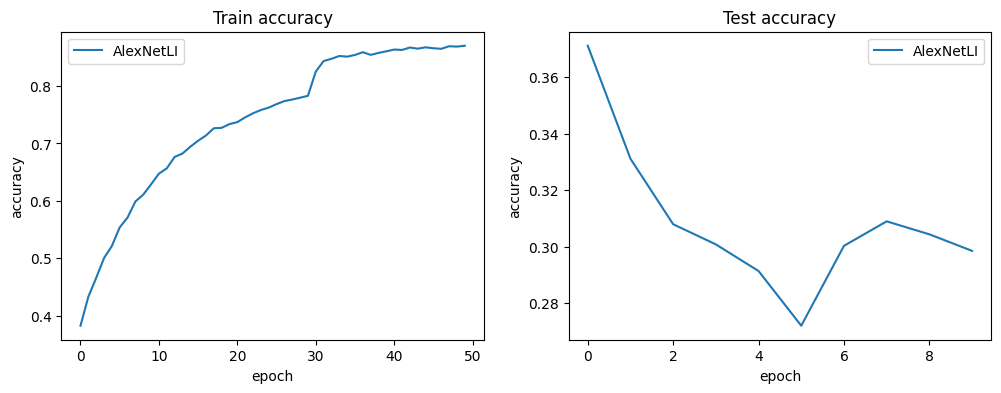

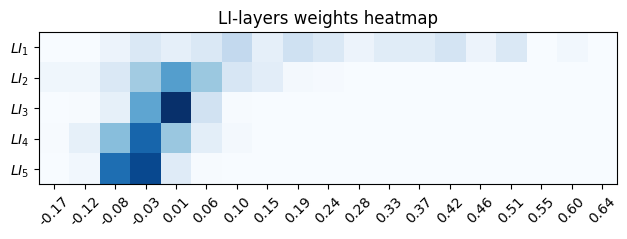

In [12]:
model_path = "logs/AlexNetLI_2"

model = torch.load(f"{model_path}/model.pth")
evaluate(model, test_loader)
plot_log(model_path)
plot_weights_heatmap(model)

### Alexnet+BatchNorm

In [6]:
class AlexNetBatchNorm(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(AlexNetBatchNorm, self).__init__()

        alexnet = models.alexnet(weights=weights)

        # Rebuild alexnet features, by adding a BatchNorm layer after each convolutions'
        # activation function
        features = list(alexnet.features.children())
        new_features = []

        for i, l in enumerate(features):
            new_features.append(l)
            if isinstance(l, nn.ReLU):
                new_features.append(nn.BatchNorm2d(features[i-1].out_channels))

        self.features = nn.Sequential(*new_features)

        # Copy all the non-convolutional parts of AlexNet
        self.avg_pool = alexnet.avgpool
        self.classifier = alexnet.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
alexnetBN = AlexNetBatchNorm().to(device)
train_model(alexnetBN, comment="_AlexNet+BatchNorm")

2023-02-13 12:13:00.554399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 12:13:01.211023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-13 12:13:01.211104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-13 12:13:01.211138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Alexnet+GroupNorm

In [ ]:
class AlexNetGroupNorm(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(AlexNetGroupNorm, self).__init__()

        alexnet = models.alexnet(weights=weights)

        # Rebuild alexnet features, by adding a LayerNorm layer after each convolutions'
        # activation function
        features = list(alexnet.features.children())
        new_features = []
        
        for i, l in enumerate(features):
            new_features.append(l)
            if isinstance(l, nn.ReLU):
                new_features.append(nn.GroupNorm(1, features[i-1].out_channels))

        self.features = nn.Sequential(*new_features)

        # Copy all the non-convolutional parts of AlexNet
        self.avg_pool = alexnet.avgpool
        self.classifier = alexnet.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
alexnetGN = AlexNetGroupNorm().to(device)
train_model(alexnetGN, comment="_AlexNet+GroupNorm")

## Resnet

### Baseline

In [ ]:
resnet18 = models.resnet18(weights="DEFAULT").to(device)
train_model(resnet18, comment="_ResNet18")

### Resnet+LI

In [ ]:
class ResNetLI(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(ResNetLI, self).__init__() 
        
        resnet = models.resnet18(weights=weights)

        self.log = {"W": [], "m": [], "v": [], "b": []}
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.li1 = LateralInhibition(self.conv1.out_channels)
        self.maxpool = resnet.maxpool

        self.layer1 = self.convert_layer_blocks(resnet.layer1)
        self.layer2 = self.convert_layer_blocks(resnet.layer2)
        self.layer3 = self.convert_layer_blocks(resnet.layer3)
        self.layer4 = self.convert_layer_blocks(resnet.layer4)
        
        # Copy all the non-convolutional parts of ResNet
        self.avgpool = resnet.avgpool
        self.fc = resnet.fc

        # Add the "plain" li params to the log
        self.log["W"].append(self.li1.weights)
        self.log["m"].append(self.li1.m)
        self.log["v"].append(self.li1.v)
        self.log["b"].append(self.li1.b)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.li1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
    def convert_layer_blocks(self, layer: nn.Sequential):
        new_layer = []

        for l in layer:
            if isinstance(l, BasicBlock):
                liblock = LIBlock(l)
                new_layer.append(liblock)
                
                self.log["W"].append(liblock.li.weights)
                self.log["m"].append(liblock.li.m)
                self.log["v"].append(liblock.li.v)
                self.log["b"].append(liblock.li.b)
            else:
                new_layer.append(l)

        return nn.Sequential(*new_layer)

In [ ]:
resnetLI = ResNetLI().to(device)
train_model(resnetLI, comment="_ResNet18+LI")

### Testing

In [ ]:
batch = enumerate(train_loader)
idx, (image, label) = next(batch)

image, label = image.to(device), label.to(device)

LI = LateralInhibition().cuda()
output = LI(image)

In [ ]:
idx = 13
img = deprocess(image[idx])
display(img)

li_img = deprocess(output[idx])
display(li_img)